In [1]:
from stackrecommender import Recommender
from stacksite import StackSite
import numpy as np
import pandas as pd
from sklearn.cross_validation import KFold
import warnings
import pickle as pkl
import sys, time
try:
    import cPickle as pkl
except:
    import pickle as pkl
import bz2
from tqdm import *

warnings.filterwarnings("ignore")

In [2]:
# start with a smaller site so things don't take fooooorever
site_name = 'datascience.stackexchange.com'

In [3]:
site = StackSite(site_name)

In [4]:
#df_dict = site.generate_dfs()

In [5]:
#site.save()

In [6]:
site.load()

Dataframes successfully loaded.


In [7]:
df_dict = site.df_dict()

In [8]:
for name in df_dict.keys():
    print name, len(df_dict[name])

users 2259
comments 1045
answers 648
questions 325
tags 152


# Generate K-Fold Test/Train Splits

I'll generate train/test splits for the questions and comments (the former is obvious, the latter is just to be fair about training the internal gensim dictionary on an appropriately smaller corpus). Then for each fold, I need to break `answers df` into two pieces according to whether the `parent_id` is in the train or test split. 

I'll treat `tags_df` as static (since according to StackExchange, it shouldn't change often), and I don't use `users_df` for anything (future features will allow `user_df` <-> `display_name` conversions).

In [9]:
df_names = ['questions', 'comments']
df_lengths = {name:len(site.df(name)) for name in df_names}

In [10]:
df_lengths

{'comments': 1045, 'questions': 325}

In [11]:
# generate the train/test split index arrays
n_folds = 5
folds = {name:KFold(df_lengths[name], n_folds=n_folds) for name in df_names}

In [12]:
# generate the train/test dataframes
train_dfs = {name:[] for name in df_names}
test_dfs = {name:[] for name in df_names}
for name in df_names:
    for train, test in folds[name]:
        train_dfs[name].append(site.df(name).ix[train])
        test_dfs[name].append(site.df(name).ix[test])

In [13]:
for j in range(n_folds):
    print len(train_dfs['questions'][j]), len(test_dfs['questions'][j])

260 65
260 65
260 65
260 65
260 65


In [14]:
train_dfs['questions'][0].head()

user_id                                              title  \
post_id                                                              
262          97       Benefits from using Hierarchical Data Format   
265         434  Can machine learning algorithms predict sports...   
266         434  What are some easy to learn machine-learning a...   
280         531  Feature selection for tracking user activity w...   
289         560                    Qualifications for PhD Programs   

                                                  tags  \
post_id                                                  
262      [hdf, data-formats, hierarchical-data-format]   
265                                 [machine-learning]   
266                                 [machine-learning]   
280                                [feature-selection]   
289                                        [education]   

                                                  question  \
post_id                                                      
262      What are the main benefits from storing data i...   
265      I have a variety of NFL datasets that I think ...   
266      Being new to machine-learning in general, I'd ...   
280      I am developing a system that is intended to c...   
289      Yann LeCun mentioned in his AMA that he consid...   

                              date  
post_id                             
262     2014-06-10 09:26:06.593000  
265     2014-06-10 10:58:58.447000  
266     2014-06-10 11:05:47.273000  
280     2014-06-10 15:08:54.073000  
289     2014-06-10 17:56:34.847000

In [15]:
# split answers_df according to the train/test split of questions_d
train_dfs['answers'] = range(n_folds)
test_dfs['answers'] = range(n_folds)
answers_df = site.df('answers').copy()

for j in range(n_folds):
    train_qids = set(train_dfs['questions'][j].index.unique()) # indices are already unique
    test_qids = set(test_dfs['questions'][j].index.unique()) # but df.index is mutable and not hashable
    train_dfs['answers'][j] = answers_df[answers_df.parent_id.isin(train_qids)]
    test_dfs['answers'][j] = answers_df[answers_df.parent_id.isin(test_qids)]

In [16]:
# pack the training sets into dictionaries of dataframes for the recommender
df_names.append('answers')
train_df_dicts = range(n_folds)
for j in range(n_folds):
    train_df_dicts[j] = {name:train_dfs[name][j] for name in df_names}
    train_df_dicts[j]['tags'] = site.df('tags')
    train_df_dicts[j]['users'] = site.df('users')

In [17]:
# users and scores are lists of users/scores lists (one list for each fold)
# question_ids is a list of lists of the corresponding question_ids
# questions is a list of lists of questions (one list for each fold)

users = [answers_df.user_id for answers_df in test_dfs['answers']]
scores = [answers_df.score for answers_df in test_dfs['answers']]
question_ids = [answers_df.parent_id for answers_df in test_dfs['answers']]
questions = range(n_folds)
for j in range(n_folds):
    questions[j] = [test_dfs['questions'][j][['title','question','tags']].ix[qid] for qid in question_ids[j]]
    
# make a list of dataframes
validate_dfs = range(n_folds)
for j in range(n_folds):
    validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
    validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
    validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])

In [20]:
for i in range(n_folds):
    validate_dfs[i]['predicted_score'] = 0.
    validate_dfs[i]['support'] = 0.

# Validate

In [21]:
import multiprocessing
multiprocessing.cpu_count()

8

In [22]:
%%time
for i in range(n_folds):
    print "Training..."
    sys.stdout.flush()
    recommender = Recommender(site_name,train_df_dicts[i])
    %time recommender.train(iterations = 100, passes = 3, multicore=7)
    print "Predicting fold", i+1
    sys.stdout.flush()
    for j in trange(len(validate_dfs[i]), leave = True):
        pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                 validate_dfs[i][['title','question','tags']].irow(j))
        validate_dfs[i]['predicted_score'][j] = pred_score
        validate_dfs[i]['support'][j] = supp

Training...


CPU times: user 42.7 s, sys: 3.1 s, total: 45.8 s
Wall time: 45.8 s
Predicting fold 1
|##########| 173/173 100% [elapsed: 00:29 left: 00:00,  5.84 iters/sec]Training...


CPU times: user 39.4 s, sys: 2.76 s, total: 42.1 s
Wall time: 42.3 s
Predicting fold 2
|##########| 172/172 100% [elapsed: 00:30 left: 00:00,  5.69 iters/sec]Training...


CPU times: user 43.4 s, sys: 3.07 s, total: 46.5 s
Wall time: 46.6 s
Predicting fold 3
|##########| 127/127 100% [elapsed: 00:27 left: 00:00,  4.63 iters/sec]Training...


CPU times: user 56.4 s, sys: 3.72 s, total: 1min
Wall time: 1min
Predicting fold 4
|##########| 111/111 100% [elapsed: 00:24 left: 00:00,  4.58 iters/sec]Training...


CPU times: user 47.8 s, sys: 3.29 s, total: 51.1 s
Wall time: 51.2 s
Predicting fold 5
|##########| 65/65 100% [elapsed: 00:12 left: 00:00,  5.03 iters/sec]CPU times: user 5min 53s, sys: 16.3 s, total: 6min 10s
Wall time: 6min 10s


*Timing Results*
---

DigitalOcean and my laptop seem about equally fast (actually, my laptop is a bit faster). `htop` reports that my code is using a *single* cpu. I need to multiprocess!!!

*DigitalOcean*

    single core LDA: Wall time 8min 7s
    multicore LDA: Wall time: 6min 10s

# Make Some Pictures!

In [19]:
def regrelerror(results, reg = 3.):
    """ 
    Regularized relative squared error (mean and std).
    a_df = answers_df (for the histogram of answer scores from multi-answerers.
    """
    scores_diff = (reg + results.predicted - results.actual)**2 / (results.actual + reg)**2
    
    return scores_diff.mean(), scores_diff.std()

def plot_results(results, title, a_df = None, hist_actual = True, supp_threshold = 3, xlim = None, ylim = None):
    
    color1 = dark2_colors[1]
    color2 = dark2_colors[2]
    color3 = dark2_colors[4]
    
    grouped_results = results.groupby('actual')
    
    plt.figure(figsize=(15,6))
    plt.suptitle(title)    
    
    plt.subplot(121)
    plt.plot(grouped_results.predicted.mean().index, grouped_results.predicted.mean(), label = "Mean Predicted Score")
    plt.scatter(results.actual, results.predicted,
                alpha = 0.1, s = 50, label = "Scores")
    plt.xlabel('Actual Answer Score')
    plt.ylabel('Predicted Score')
    if xlim:
        plt.xlim(-1,xlim)
    else: plt.xlim(-1,results.actual.max())
    if ylim:
        plt.ylim(-1,ylim)
    else: plt.ylim(-1,results.predicted.max())
    x = np.linspace(-1, 30)
    plt.plot(x,x,'r-', alpha = 0.3, label = r'$100\%$ Accuracy')
    plt.legend(loc='upper left')
    remove_border()

    plt.subplot(122)
    bins = np.linspace(-3,30,32)
    if hist_actual:
        results.actual.hist(bins = bins, alpha = 0.5, label="Actual", color = color1)
        
    if a_df is not None:
        results.actual.hist(bins = bins, alpha = 0.1, label="Actual", color = color1)
        #here's a historgram of the scores from users who answered more than one question (where I had a chance)
        min_questions_answered = 3
        user_answers = a_df.groupby('user_id')
        multi_answerers = user_answers.score.mean()[user_answers.score.count() >= min_questions_answered].index
        malist = set(multi_answerers.tolist())
        xh, yh, oh = plt.hist(a_df[a_df.user_id.isin(malist)].score, bins = bins, 
                                                   alpha = 0.5, color=color2,
                                                   label="Actual (supp > %d)" % (supp_threshold - 1))

        plt.ylim(0, 1.1 * max(xh))

    results.predicted.hist(bins = bins, alpha = 0.5, label="Predicted", color=color3)
    plt.legend(loc='upper right')
    remove_border()
    
    plt.show()
    
    print "Regularized relative squared error (mean, std):", regrelerror(results)
    print "-"*20
    print
    
    return

LDA

    num_topics = 20
    iterations = 100
    passes = 3
    k = 7
    w = [1,1,1] (title, question, tags)

In [20]:
results1 = pd.DataFrame(columns=['actual','predicted','support'])
results1.actual = pd.concat([vdf.score for vdf in validate_dfs])
results1.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
results1.support = pd.concat([vdf.support for vdf in validate_dfs])

In [25]:
with bz2.BZ2File('data/'+site_name+'/five-fold-results_100it-3ps-20tp.bzpkl','wb') as f:
    pkl.dump(results1, f)

In [21]:
results1.head()

actual  predicted  support
parent_id                            
5               3   1.708333        0
7               8   1.708333        0
19             13   1.708333        0
7               5   2.666667        2
22             13   1.708333        0

In [22]:
len(results1[results1.predicted.isnull()])

0

In [23]:
recommender.avg_new_user_score

2.2018348623853212

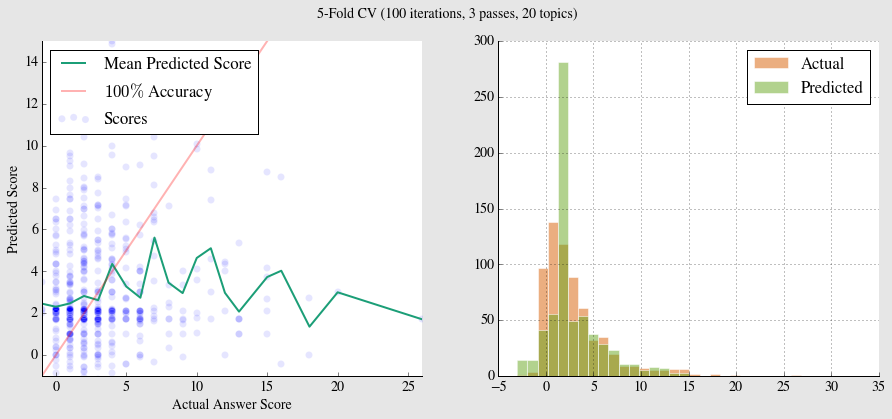

Regularized relative squared error (mean, std): (1.3459259244577582, 2.9143218442682515)
--------------------



In [26]:
plot_results(results1, '5-Fold CV (100 iterations, 3 passes, 20 topics)')

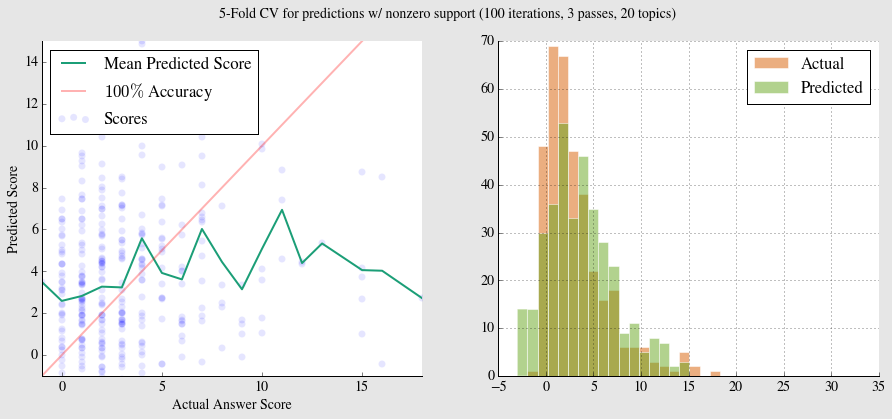

Regularized relative squared error (mean, std): (1.5067845294805775, 2.8150307270386312)
--------------------



In [27]:
plot_results(results1[results1.support > 0], '5-Fold CV for predictions w/ nonzero support (100 iterations, 3 passes, 20 topics)')

In [34]:
import sklearn.metrics
print "\nmean squared: ", sklearn.metrics.mean_squared_error(results1.actual, results1.predicted)
print "mean absolute: ", sklearn.metrics.mean_absolute_error(results1.actual, results1.predicted)
print "R^2", sklearn.metrics.r2_score(results1.actual, results1.predicted)

 
mean squared:  17.1540461208
mean absolute:  2.91270351378
R^2 -0.557605707919


# Cross-Validation (function w/ params)

In [28]:
def cv_recommender(k = 7, w = [1,1,1], num_topics = 20, iterations = 50, passes = 5):
    """
    Uses the n_fold train/test splits to validate with the given parameters. Outputs 
    a dataframe with columns 'actual' and 'predicted'.
    
    WARNING: super hacky!
    """
    
    # make a list of dataframes
    validate_dfs = range(n_folds)
    for j in range(n_folds):
        validate_dfs[j] = pd.DataFrame(data=questions[j], index=question_ids[j])
        validate_dfs[j]['user_id'] = pd.Series(data=users[j].values, index=question_ids[j])
        validate_dfs[j]['score'] = pd.Series(data=scores[j].values, index=question_ids[j])
        
    for i in range(n_folds):
        validate_dfs[i]['predicted_score'] = 0.
        validate_dfs[i]['support'] = 0.

    for i in range(n_folds):
        recommender = Recommender(site_name, train_df_dicts[i])
        recommender.train(num_topics = num_topics, iterations = iterations, passes = passes)
        for j in range(len(validate_dfs[i])):
            pred_score, supp = recommender.predicted_score(validate_dfs[i].user_id.irow(j), 
                                                     validate_dfs[i][['title','question','tags']].irow(j),
                                                     k = k, w = w)
            validate_dfs[i]['predicted_score'][j] = pred_score
            validate_dfs[i]['support'][j] = supp
            
    results = pd.DataFrame(columns=['actual','predicted','support'])
    results.actual = pd.concat([vdf.score for vdf in validate_dfs])
    results.predicted = pd.concat([vdf.predicted_score for vdf in validate_dfs])
    results.support = pd.concat([vdf.support for vdf in validate_dfs])
    
    return results

In [29]:
%%time
results2 = cv_recommender(num_topics=100, iterations=1000, passes=2)

CPU times: user 12min 32s, sys: 10.5 s, total: 12min 43s
Wall time: 6min 37s


LDA

    num_topics = 100
    iterations = 1000
    passes = 2
    k = 7
    w = [1,1,1] (title, question, tags)

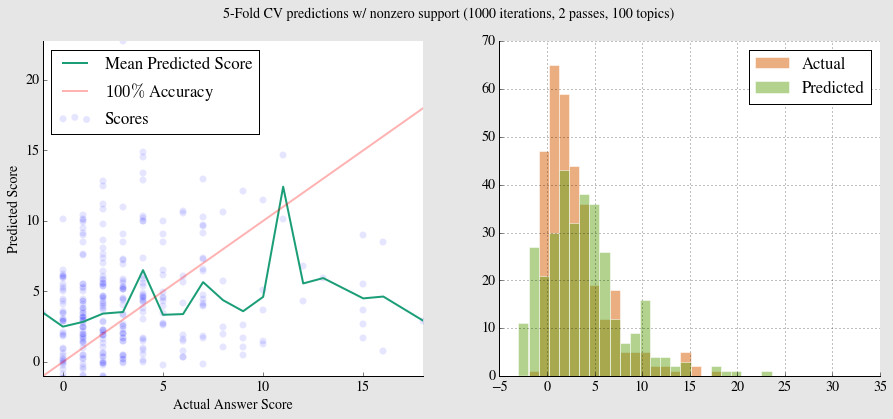

Regularized relative squared error (mean, std): (1.7310800083495304, 3.8583661532956648)
--------------------



In [30]:
plot_results(results2[results2.support >0], '5-Fold CV predictions w/ nonzero support (1000 iterations, 2 passes, 100 topics)')

Things to check/do:

1. keep some predictions with support 0? (need more features: comments, comment scores, reputation)
2. feed Tfidf vectors into LDA.